In [1]:
upstream = ["run_ss"]
product = None
model = None
dataset = None
legendclean = None
legendalt = None

In [2]:
# Parameters
model = "molformer"
dataset = "bbbp_finetune"
legendclean = "$H_0$ embeddings"
legendalt = "$H_1$ embeddings"
upstream = {"run_ss": {"nb": "/Users/celiacintas/Code/PDSS_private/output/molformer/bbbp_finetune/group/hc/runs_ss.ipynb", "clean_output": "/Users/celiacintas/Code/PDSS_private/output/molformer/bbbp_finetune/group/hc/clean_output.out", "adv_output": "/Users/celiacintas/Code/PDSS_private/output/molformer/bbbp_finetune/group/hc/adv_output.out", "indices": "/Users/celiacintas/Code/PDSS_private/output/molformer/bbbp_finetune/group/hc/indices.pkl"}}
product = {"nb": "/Users/celiacintas/Code/PDSS_private/output/molformer/bbbp_finetune/group/hc/plot_results.ipynb"}


In [3]:
from pathlib import Path
import pickle

abnormal_path = Path(upstream["run_ss"]["adv_output"])
clean_path = Path(upstream["run_ss"]["clean_output"])
indices = pickle.loads(Path(upstream["run_ss"]["indices"]).read_bytes())

In [4]:
print(indices)

[[(array([235,  10,  96,  47, 153, 358,  69, 143, 364, 261,  40, 140, 392,
       380, 388, 178, 271,  80, 223, 288,  83, 336,  28, 207,  38, 105,
       190, 327, 210,  50, 334,  79,   2,  71, 206,  45, 216, 138, 378,
       290,   6, 213, 260, 212, 120, 263, 238, 239, 320, 208, 373,  86,
       343, 160, 394, 361, 249, 102, 295, 310, 342, 289, 113, 390, 349,
       326, 357, 164, 365,   1, 252,  29, 315, 195,  87, 236,   4,  70,
        75, 124, 305, 292, 156, 362, 280, 234,  76,  64,  46, 144,  20,
       398,  77, 122, 376, 316, 111, 259,  74, 115, 250, 300, 224, 209,
       172, 142, 389, 298, 183, 189,  52,  62,  66, 333, 137, 230, 177,
        11, 181, 159, 381, 226, 227, 322, 265, 108, 154, 163, 254,  31,
       384,  58, 262, 383, 399,  84, 297, 396, 119, 306, 283, 173, 240,
        54, 145, 219, 312, 285, 341, 180, 136, 203, 182, 277, 314, 112,
       391, 366, 313, 121, 130,  48, 368,  93,   0,  44, 377, 273, 169,
       202, 128, 193, 198,  32, 256, 196,  49, 372, 149, 167,

In [5]:
import matplotlib.pyplot as plt
from util.resultparser import ResultParser, ResultSelector


def load_results(clean_fn, fake_fn):
    resultselector = ResultSelector(score=True)
    a = ResultParser.get_results(clean_fn, resultselector)
    b = ResultParser.get_results(fake_fn, resultselector)
    clean_scores = np.array(a["scores"])
    anom_scores = np.array(b["scores"])

    return clean_scores, anom_scores

In [6]:
import seaborn as sns
from sklearn import metrics
import numpy as np

plt.rcParams.update({"font.size": 11})
pal = sns.color_palette("Set2")

sns.set_palette(pal)


def plot_layer(model, clean_fn, fake_fn):
    """get name of layer and load subset scores from BIM attacks and
    clean images and display score distribution and AUC"""
    clean_scores, anom_scores = load_results(clean_fn=clean_fn, fake_fn=fake_fn)
    clean_scores = clean_scores[~np.isinf(clean_scores)]
    anom_scores = anom_scores[~np.isinf(anom_scores)]

    sns.set(style="darkgrid")
    sns.histplot(
        clean_scores,
        element="step",
        stat="density",
        kde=True,
        color="green",
        label=legendclean,
    )
    sns.histplot(
        anom_scores,
        element="step",
        stat="density",
        kde=True,
        color="purple",
        label=legendalt,
    )

    plt.title("Distribution of subset scores for - {} - {}".format(model, dataset))
    plt.legend()
    plt.ylabel("Density")
    plt.xlabel("Subset Score")
    y_true = np.append([np.ones(len(anom_scores))], [np.zeros(len(clean_scores))])
    all_scores = np.append([anom_scores], [clean_scores])

    fpr, tpr, thresholds = metrics.roc_curve(y_true, all_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print("AUC: {}".format(roc_auc))
    plt.show()

AUC: 0.998375


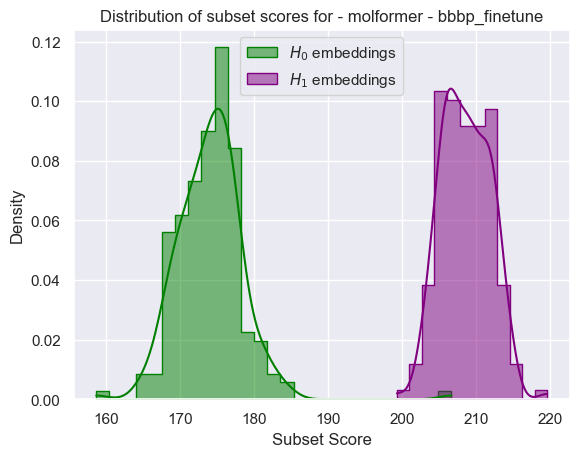

In [7]:
plot_layer(model, clean_path, abnormal_path)

In [8]:


def get_anom_nodes(fn="results/"):
    """
    Extract from output file the list of nodes that were found anom.
    remove end of line and return an int list of positions.
    """
    nodes_samples = []
    images_samples = []
    # precision_samples = []
    # recall_samples = []
    optimal_alpha_samples = []
    with open(fn, "r") as f:
        for line in f.readlines()[:-1]:
            # print(line.rstrip().split(' '))
            if "inf" in line.rstrip().split(" "):
                pass
            else:
                (
                    _,
                    _,
                    _,
                    _,
                    _,
                    optimal_alpha,
                    anom_node,
                    anom_images,
                ) = line.rstrip().split(" ")
                nodes = anom_node.strip().split(",")
                images = anom_images.strip().split(",")
                if nodes != [""]:
                    nodes = list(map(int, nodes))
                images = list(map(int, images))
                nodes_samples.append(np.array(nodes))
                images_samples.append(images)
                optimal_alpha_samples.append(float(optimal_alpha))

    return (
        nodes_samples,
        images_samples,
        _,
        _,
        optimal_alpha_samples,
    )

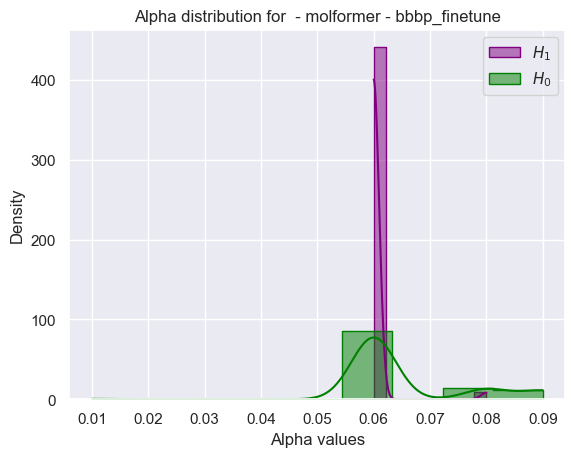

/var/folders/g7/q2thzs6n26v42rmgpzd50s1m0000gn/T/ipykernel_32225/322980063.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nodes_fake, label=legendalt, color="purple")


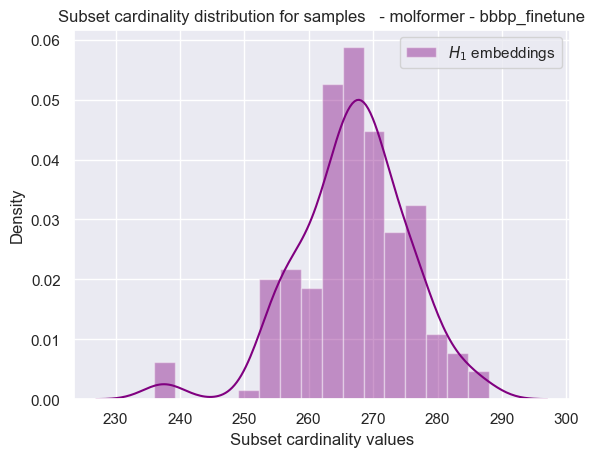

In [9]:

nodes_fake, _, _, _, optimal_alpha_samples_fake = get_anom_nodes(abnormal_path)
nodes_clean, _, _, _, optimal_alpha_samples_clean = get_anom_nodes(clean_path)

optimal_alpha_samples_fake = np.array(optimal_alpha_samples_fake)
optimal_alpha_samples_clean = np.array(optimal_alpha_samples_clean)
nodes_fake = np.array([len(n) for n in nodes_fake])
plt.title("Alpha distribution for  - {} - {}".format(model, dataset))
sns.histplot(
    optimal_alpha_samples_fake,
    element="step",
    stat="density",
    kde=True,
    color="purple",
    label="$H_1$",
)
sns.histplot(
    optimal_alpha_samples_clean,
    element="step",
    stat="density",
    kde=True,
    color="green",
    label="$H_0$",
)
plt.xlabel("Alpha values")
plt.ylabel("Density")
plt.legend()
plt.show()
plt.title(
    "Subset cardinality distribution for samples   - {} - {}".format(model, dataset)
)
plt.xlabel("Subset cardinality values")
plt.ylabel("Density")
sns.distplot(nodes_fake, label=legendalt, color="purple")
plt.legend()
plt.show()

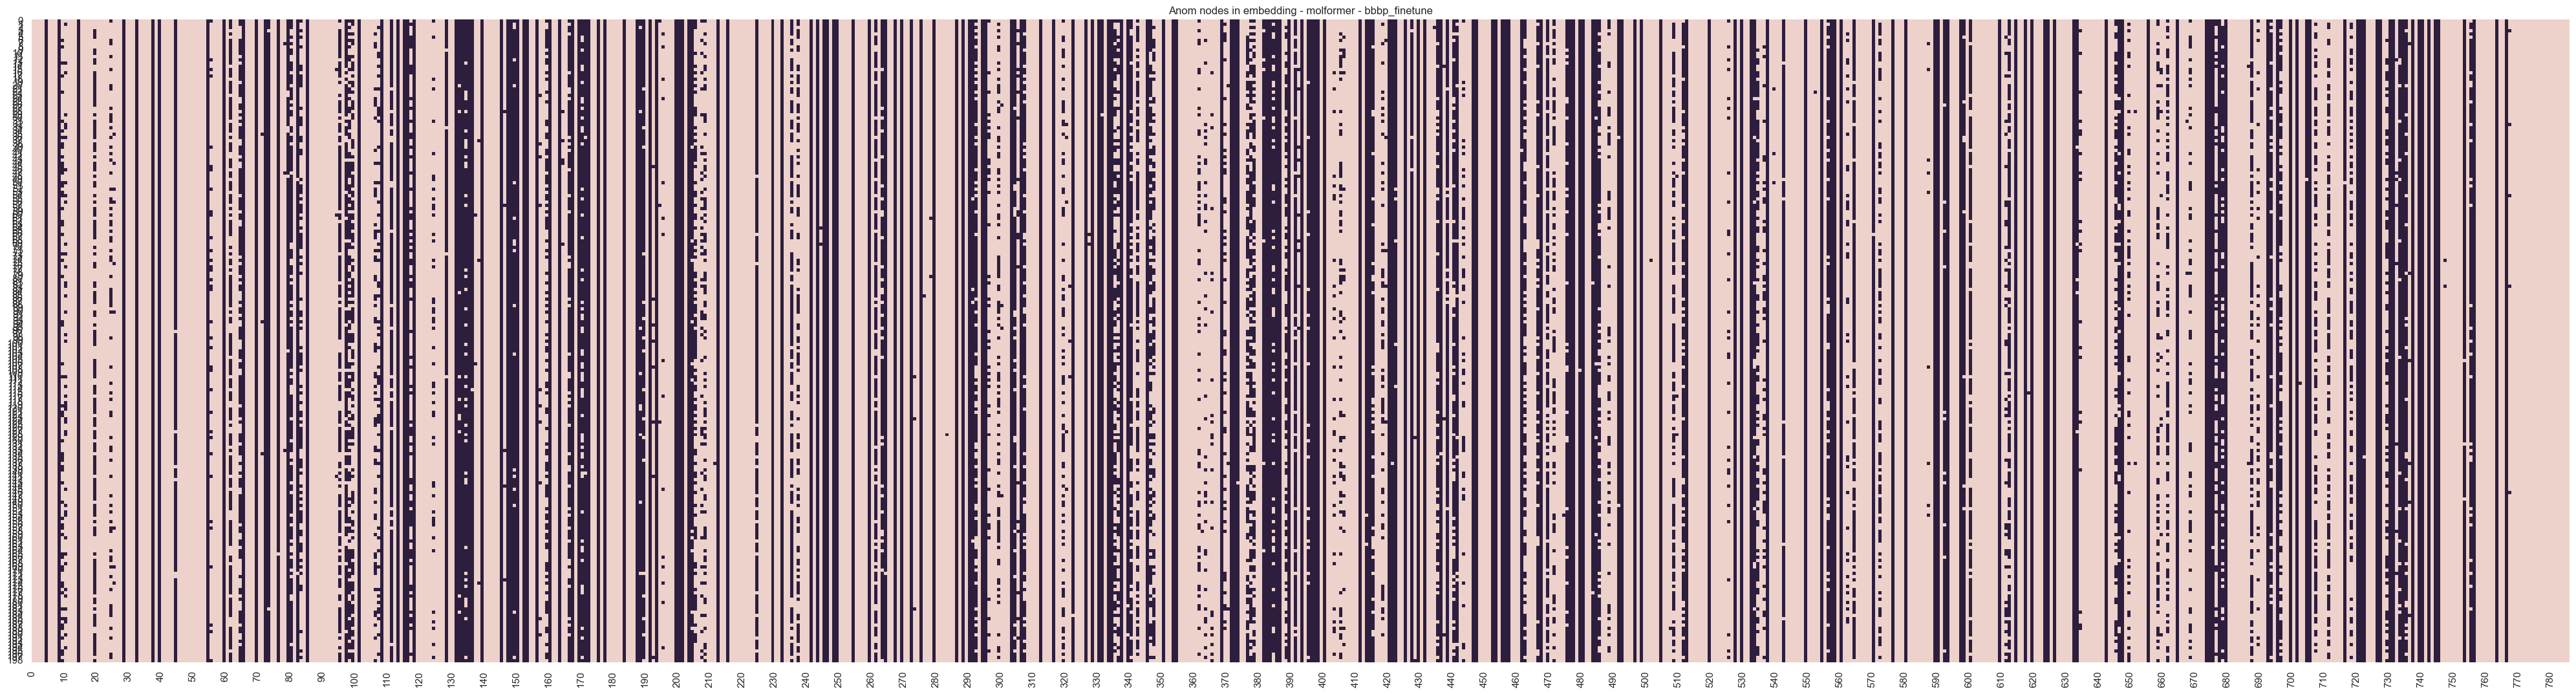

In [10]:
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sb
import matplotlib.ticker as ticker

nodes_fake, molecule_samples, precision, recall, optimal_alpha_samples_fake = (
    get_anom_nodes(abnormal_path)
)


def draw_anoms(nodes, class_target="", shape=(1, 786)):
    """
    Mark as 1 anomalous nodes in the shape parameter,
    rest of the nodes is mark as 0.
    """
    zeros = np.zeros(shape[1])
    np.put(zeros, nodes, 1)
    return zeros.reshape(shape)


all_viz = list()
for i, node in enumerate(nodes_fake):
    # if precision[i] >= 0.75:
    all_viz.append(draw_anoms(node))
palet = sb.cubehelix_palette(8)
plt.figure(figsize=(40, 40))
plt.title("Anom nodes in embedding - {} - {}".format(model, dataset))
heat_map = sb.heatmap(
    np.array(all_viz).reshape(-1, 786),
    fmt="",
    square=True,
    cbar_kws={"shrink": 0.5},
    cmap=palet,
    cbar=False,
)
heat_map.xaxis.set_major_locator(ticker.MultipleLocator(10))
heat_map.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()
plt.show()

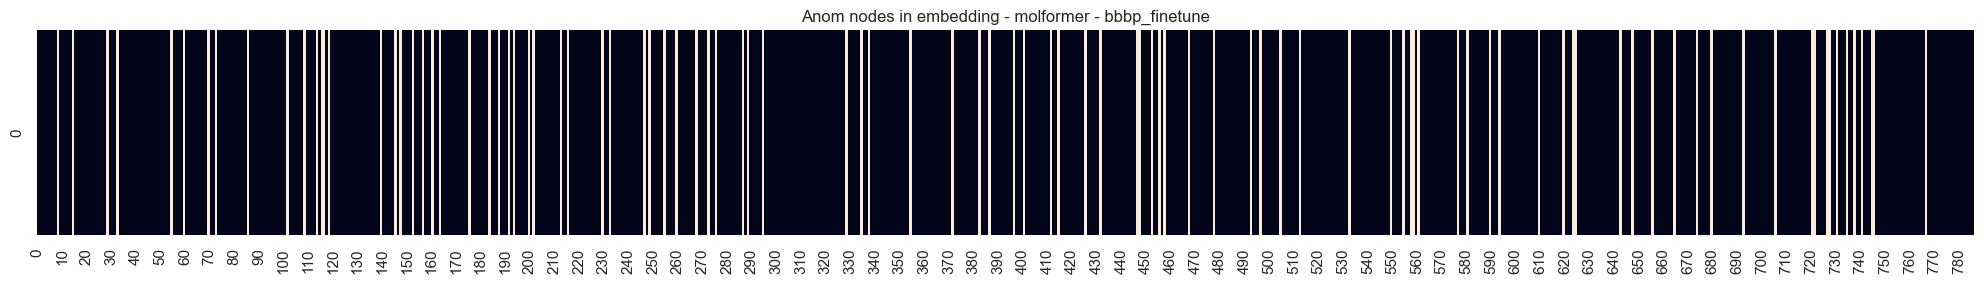

In [11]:
from collections import Counter

flat_nodes = [node for run in nodes_fake for node in run]
flat_nodes_count = Counter(flat_nodes)
values, counts = zip(*flat_nodes_count.most_common(100))

# sb.set(style="darkgrid")
plt.figure(figsize=(20, 3))
plt.title("Anom nodes in embedding - {} - {}".format(model, dataset))
heat_map = sb.heatmap(
    draw_anoms(values).reshape(-1, 786),
    fmt="",
    square=False,
    cbar_kws={"shrink": 0.5},
    cbar=False,
)
heat_map.xaxis.set_major_locator(ticker.MultipleLocator(10))
heat_map.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tight_layout()
plt.show()